In [3]:
import torch
import torch.nn as nn
from stabnode.node import MLP
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from data.budworm import simulate_trials
from sklearn.preprocessing import MinMaxScaler

In [4]:
class GeluSigmoidMLPfeaturized(nn.Module):
    def __init__(
        self,
        dims,
        activation = torch.nn.SiLU(),
        lower_bound=0,
        upper_bound=1,
        freq_sample_step = 5
    ):
        super().__init__()

        self.dims = dims
        self.activation = activation
        self.network = MLP(self.dims, activation = self.activation)

        self.freq_sample_step = freq_sample_step
        self.featurization_dim = dims[0] - 2
        self.freqs = torch.arange(0,self.featurization_dim*self.freq_sample_step,self.freq_sample_step)
        

        self.args = {
            "lower_bound": lower_bound,
            "upper_bound": upper_bound
        }

    def forward(self,x,u):
        a = self.args['lower_bound']
        b = self.args['upper_bound']
        x_feats = [x]
        for fq in self.freqs:
            x_feats.append(torch.cos(fq**2*3.14*(x- a)/(b-a)))
        xf = torch.cat(x_feats,dim=-1)
        xu = torch.cat([xf,u],dim=-1)


        return a + (b-a)*torch.sigmoid(self.network(xu))

In [5]:
g = GeluSigmoidMLPfeaturized(dims = [6,10,10,1], activation = torch.nn.SiLU(), lower_bound = 0, upper_bound = 1, freq_sample_step = 1 )

In [6]:
freqs = g.freqs
a = g.args["lower_bound"]
b = g.args["upper_bound"]

In [7]:
a,b

(0, 1)

In [8]:
# x = np.linspace(0,1,101)

## Generate more interesting data
k = 8.5

xs = []
ts = []
x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

In [9]:
scaler = MinMaxScaler()
scaler.fit(np.concatenate(xs).reshape(-1,1))

xs_scaled = [scaler.transform(xi.reshape(-1,1)).reshape(-1) for xi in xs]

In [10]:
x = xs_scaled[-1]

In [11]:
freqs

tensor([0, 1, 2, 3])

In [12]:
x_feats = [x]
a,b=0,1
for fq in freqs:
    x_feats.append(np.cos(fq**2*3.14*(x- a)/(b-a)))

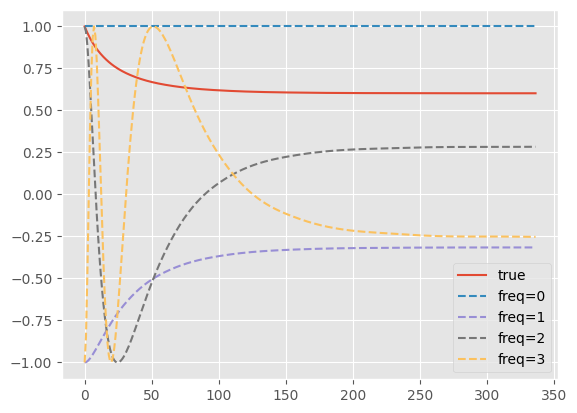

In [13]:

for idx, xi in enumerate(x_feats):
    if idx ==0:
        plt.plot(xi,label='true')
    else:
        plt.plot(xi, label=f"freq={freqs[idx-1]}",linestyle='--')
    
plt.legend()
plt.show()

## Learn $\tilde g$

In [14]:
from data.budworm import g_true, f_true

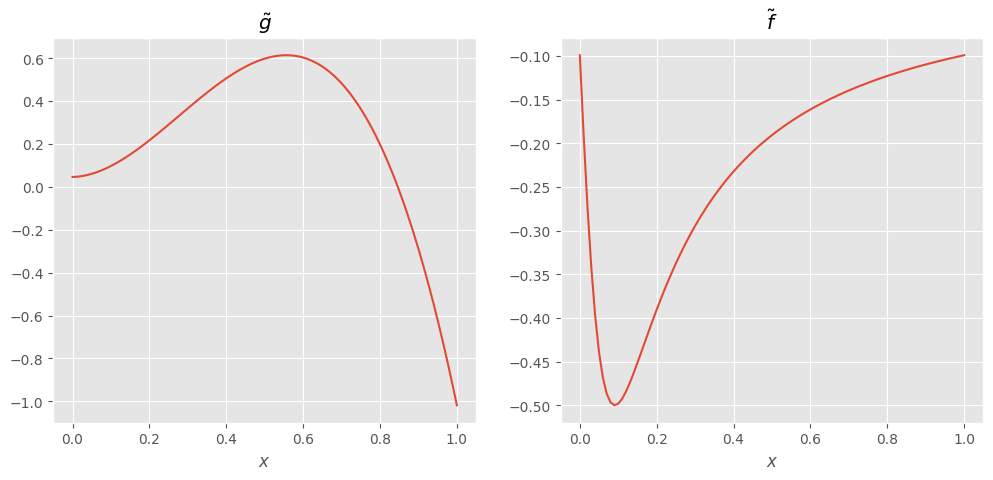

In [16]:
x_lin = np.linspace(0,1,101)
x_lin_unscaled = scaler.inverse_transform(x_lin.reshape(-1,1)).reshape(-1)

f_true_arr = f_true(x_lin_unscaled)
g_true_arr = scaler.transform(g_true(x_lin_unscaled, k, r=0.56).reshape(-1,1)).reshape(-1)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(x_lin, g_true_arr)
ax1.set_title(r"$\tilde{g}$")
ax1.set_xlabel(r"$x$")
ax2.plot(x_lin, f_true_arr)
ax2.set_title(r"$\tilde{f}$")
ax2.set_xlabel(r"$x$")
plt.show()

## Try Learning Polynomial Approximation with Feature library regression?


$$
\dot x = rx (1-x/k) - \frac{x^2}{1+x^2}
$$

$$
g = \frac{r}{k}(1+x^2)(k-x) \quad \text{and} \quad f = -\frac{x}{1+x^2}
$$

$$
g(x,k)=-\frac{r}{k}x^3 + rx^2 -\frac{r}{k}x +r 
$$

$$
f'(x) = \frac{x^2 - 1}{(1+x^2)^2}
$$

$$
f''(x) = -\frac{2x(x^2 - 3)}{(1+x^2)^3}
$$

$$
f^{(3)}(x) = \frac{6(x^4 - 6x^2 + 1)}{(1+x^2)^4}
$$

$$
f^{(4)}(x) = -\frac{24x(x^4 - 10x^2 + 5)}{(1+x^2)^5}
$$

$$
f^{(5)}(x) = \frac{120(x^6 - 15x^4 + 15x^2 - 1)}{(1+x^2)^6}
$$


$$
\mathcal{P}(f) = f(x_0) + f'(x_0)(x-x_0) + \frac{1}{2}f''(x_0)(x-x_0)^2 + \frac{1}{3!} \mathcal{O}(x-x_0)^3
$$

In [ ]:
f = lambda x: - x / (1+x**2)
df = lambda x: (x**2 - 1) / (1+x**2)**2
d2f = lambda x: - 2*x*(x**2-3) / (1+x**2)**3
d3f = lambda x: 6*(x**4-6*x**2 + 1) / (1+x**2)**4
d4f = lambda x: - 24*x*(x**4-10*x**2 + 5) / (1+x**2)**5
d5f = lambda x: 120*(x**6-15*x**4+15*x**2-1) / (1+x**2)**6


In [25]:
def poly_f(x,x0=5):
    term1 = f(x0) + df(x0)*(x-x0) + (1/2)*d2f(x0)*(x-x0)**2 
    term2 = (1/6)*d3f(x0)*(x-x0)**3 + (1/24)*d4f(x0)*(x-x0)**4
    term3 = (1/120)*d5f(x0)*(x-x0)**5
    return term1+term2+term3

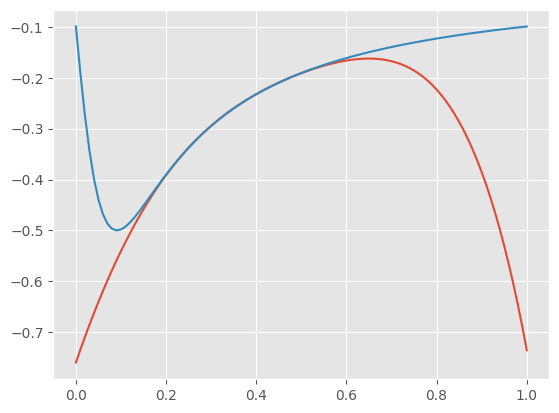

In [36]:
x0=3.5
plt.plot(x_lin,poly_f(x_lin_unscaled,x0))
plt.plot(x_lin, f_true_arr)

In [37]:
import sympy as sp

# Define symbols
x, x0 = sp.symbols('x x0')
f = -x / (1 + x**2)

# Choose order of expansion
N = 6   # up to (x-x0)^5 term

# Taylor expansion of f(x) around x0
series = sp.series(f, x, x0, N).removeO()
print(f"Taylor expansion around x0 (order {N-1}):")
print(series)

# Function to get k-th derivative at x0
def derivative_at_x0(k):
    return sp.diff(f, x, k).subs(x, x0)

# Example: first 5 derivatives at x0
for k in range(1, 6):
    print(f"f^{k}({x0}) =", derivative_at_x0(k))


Taylor expansion around x0 (order 5):
-x0/(x0**2 + 1) + (x - x0)**5*(-x0*(-32*x0**5/(x0**2 + 1)**5 + 32*x0**3/(x0**2 + 1)**4 - 6*x0/(x0**2 + 1)**3)/(x0**2 + 1) - (16*x0**4/(x0**2 + 1)**4 - 12*x0**2/(x0**2 + 1)**3 + (x0**2 + 1)**(-2))/(x0**2 + 1)) + (x - x0)**4*(-x0*(16*x0**4/(x0**2 + 1)**4 - 12*x0**2/(x0**2 + 1)**3 + (x0**2 + 1)**(-2))/(x0**2 + 1) - (-8*x0**3/(x0**2 + 1)**3 + 4*x0/(x0**2 + 1)**2)/(x0**2 + 1)) + (x - x0)**3*(-x0*(-8*x0**3/(x0**2 + 1)**3 + 4*x0/(x0**2 + 1)**2)/(x0**2 + 1) - (4*x0**2/(x0**2 + 1)**2 - 1/(x0**2 + 1))/(x0**2 + 1)) + (x - x0)**2*(-x0*(4*x0**2/(x0**2 + 1)**2 - 1/(x0**2 + 1))/(x0**2 + 1) + 2*x0/(x0**2 + 1)**2) + (x - x0)*(2*x0**2/(x0**2 + 1)**2 - 1/(x0**2 + 1))
f^1(x0) = 2*x0**2/(x0**2 + 1)**2 - 1/(x0**2 + 1)
f^2(x0) = 2*x0*(-4*x0**2/(x0**2 + 1) + 3)/(x0**2 + 1)**2
f^3(x0) = 6*(4*x0**2*(2*x0**2/(x0**2 + 1) - 1)/(x0**2 + 1) - 4*x0**2/(x0**2 + 1) + 1)/(x0**2 + 1)**2
f^4(x0) = 24*x0*(-16*x0**4/(x0**2 + 1)**2 + 20*x0**2/(x0**2 + 1) - 5)/(x0**2 + 1)**3
f^5(x0) = 120

In [38]:
import sympy as sp

def taylor_polynomial(f, x, x0, N):
    """
    Compute the Taylor polynomial of f(x) around x0 up to order N.
    
    f  : sympy expression
    x  : sympy symbol (variable)
    x0 : point of expansion
    N  : order of polynomial (max power of (x-x0))
    """
    return sp.series(f, x, x0, N+1).removeO()

def taylor_coefficients(f, x, x0, N):
    """
    Return list of Taylor coefficients a_k for k=0,...,N
    where f(x) = sum_{k=0}^N a_k (x-x0)^k + ...
    
    a_k = f^(k)(x0)/k!
    """
    coeffs = []
    for k in range(N+1):
        deriv_k = sp.diff(f, x, k).subs(x, x0)
        coeffs.append(sp.simplify(deriv_k / sp.factorial(k)))
    return coeffs


# --------------------------
# Example usage
# --------------------------

x = sp.symbols('x')
f = -x / (1 + x**2)

x0 = 1   # center
N = 5    # up to (x-x0)^5

# Get Taylor polynomial
poly = taylor_polynomial(f, x, x0, N)
print("Taylor polynomial:", poly)

# Get coefficients
coeffs = taylor_coefficients(f, x, x0, N)
print("Taylor coefficients a_k:")
for k, a in enumerate(coeffs):
    print(f"a_{k} =", a)


Taylor polynomial: (x - 1)**4/8 - (x - 1)**3/4 + (x - 1)**2/4 - 1/2
Taylor coefficients a_k:
a_0 = -1/2
a_1 = 0
a_2 = 1/4
a_3 = -1/4
a_4 = 1/8
a_5 = 0


In [39]:
poly

(x - 1)**4/8 - (x - 1)**3/4 + (x - 1)**2/4 - 1/2

In [63]:
import sympy as sp
import numpy as np

def taylor_polynomial_function(f, x, x0, N):
    """
    Return a callable Python function representing the truncated Taylor
    expansion of f(x) around x0 up to order N.
    
    f  : sympy expression
    x  : sympy symbol (variable)
    x0 : center of expansion (numeric)
    N  : order of expansion (max power of (x-x0))
    """
    # Generate Taylor polynomial (SymPy expression)
    poly = sp.series(f, x, x0, N+1).removeO()
    
    # Convert to a fast numerical function
    poly_func = sp.lambdify(x, poly, "numpy")
    
    return poly, poly_func


# --------------------------
# Example usage
# --------------------------

# Define variable and function
x = sp.symbols('x')
f = -x / (1 + x**2)

# Expansion center and order
x0 = 5  # center point
N = 30      # order

# Get Taylor polynomial and callable
poly_expr, poly_func = taylor_polynomial_function(f, x, x0, N)

print("Taylor polynomial around x0=1 up to order 5:")
print(poly_expr)

# Evaluate at some test points
points = [0.8, 1.0, 1.2, 1.5]
print("\nEvaluations of polynomial approximation:")
for p in points:
    print(f"P({p}) = {poly_func(p):.6f},   f({p}) = {float(f.subs(x, p)):.6f}")


Taylor polynomial around x0=1 up to order 5:
6*x/169 - 257499110199672665*(x - 5)**30/2232152448529156308005497643127907090432 + 11970224587477467*(x - 5)**29/21463004312780349115437477337768337408 - 17023836407648155*(x - 5)**28/6604001327009338189365377642390257664 + 2864483360640839*(x - 5)**27/254000051038820699590976063168856064 - 893922861443095*(x - 5)**26/19538465464524669199305851012988928 + 30867902818743*(x - 5)**25/187869860235814126916402413586432 - 26214865485125*(x - 5)**24/57806110841788962128123819565056 + 584824319281*(x - 5)**23/2223311955453421620312454598656 + 1566663253255*(x - 5)**22/171023996573340124639419584512 - 161887318953*(x - 5)**21/1644461505512885813840572928 + 377602269605*(x - 5)**20/505988155542426404258637824 - 95420159401*(x - 5)**19/19461082905477938625332224 + 44353794185*(x - 5)**18/1497006377344456817333248 - 2429784837*(x - 5)**17/14394292089850546320512 + 4064430715*(x - 5)**16/4429012950723245021696 - 815616479*(x - 5)**15/170346651950894039

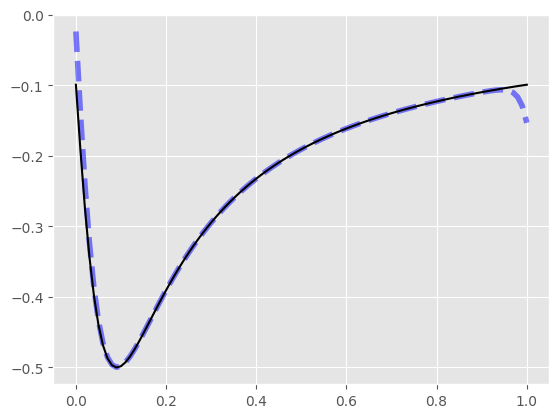

In [64]:
plt.plot(x_lin, poly_func(x_lin_unscaled), linestyle='--', color='blue', alpha=0.5, lw=4)
plt.plot(x_lin, f_true_arr, c='black')
plt.show()

## Look at time to steady as a relation to the values of $f$

In [65]:
k=8.5